# Supplementary data for "The Life Cycle of Structural Biology Data"
This paper was submitted to the Data Science Journal.

TODO https://www.ebi.ac.uk/pdbe/search/pdb/select?rows=0&q=status:REL&json.facet={deposition_year:{type:range,start:1971,end:2018,gap:1,field:deposition_year,limit:20,facet:{homo_hetero:{type:terms,%20field:assembly_form,facet:{facet:{type:terms,field:assembly_composition,facet:{grouped_assemblycomposition_count:%22unique(pdb_id)%22}},grouped_homo_hetero_count:%22unique(pdb_id)%22}},grouped_depositionyear_count:%22unique(pdb_id)%22}}}

## New Entries Released Each Year

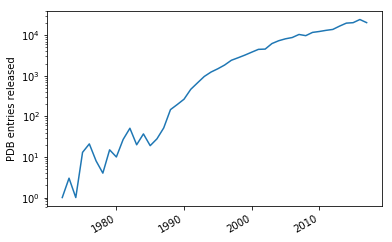

In [5]:
PDBE_SOLR_URL = "http://www.ebi.ac.uk/pdbe/search/pdb"                 
# or https://www.ebi.ac.uk/pdbe/search/pdb/select?rows=0&q=status:REL&wt=json

from mysolr import Solr
solr = Solr(PDBE_SOLR_URL, version=4)

response = solr.search(**{
        "rows" : 0, # "fl" : "deposition_year", 
        "q" : 'status:REL',
        "facet" : "true", "facet.limit" : 1000000, "facet.mincount" : 1,
        "facet.field" : "deposition_year",
    }
)
from matplotlib import pyplot as plt

# skip current year, which is not yet complete
years = sorted( response.facets['facet_fields']['deposition_year'] )[0:-1]

fig = plt.figure()
plt.yscale('log')
plt.ylabel('PDB entries released')
plt.plot(years, [ response.facets['facet_fields']['deposition_year'][year] for year in years])
plt.xticks(['1980', '1990', '2000', '2010'])
fig.autofmt_xdate()
plt.show()

In [6]:
response = solr.search(**{
        "rows" : 0, "fl" : "deposition_year", 
        "q" : 'status:REL',
        'json.facet': """{
            deposition_year:{
                type:range,start:1971,end:2018,gap:1,field:deposition_year,limit:20,
                facet:{
                    homo_hetero:{
                        type:terms, field:assembly_form,
                        facet:{
                            facet:{
                                type:terms,field:assembly_composition,
                                facet:{grouped_assemblycomposition_count:\"unique(pdb_id)\"}
                            },
                            grouped_homo_hetero_count:\"unique(pdb_id)\"
                        }
                    },
                    grouped_depositionyear_count:\"unique(pdb_id)\"
                }
            }
        }"""
    }
)
response.raw_content

{'responseHeader': {'status': 0,
  'QTime': 59,
  'params': {'q': 'status:REL',
   'json.facet': '{\n            deposition_year:{\n                type:range,start:1971,end:2018,gap:1,field:deposition_year,limit:20,\n                facet:{\n                    homo_hetero:{\n                        type:terms, field:assembly_form,\n                        facet:{\n                            facet:{\n                                type:terms,field:assembly_composition,\n                                facet:{grouped_assemblycomposition_count:"unique(pdb_id)"}\n                            },\n                            grouped_homo_hetero_count:"unique(pdb_id)"\n                        }\n                    },\n                    grouped_depositionyear_count:"unique(pdb_id)"\n                }\n            }\n        }',
   'fl': 'deposition_year',
   'rows': '0',
   'wt': 'json'}},
 'response': {'numFound': 237223, 'start': 0, 'docs': []},
 'facets': {'count': 237223,
  'depositi

In [33]:
response.raw_content['facets']['deposition_year']['buckets'][-4] 

{'val': 2014,
 'count': 19875,
 'grouped_depositionyear_count': 9365,
 'homo_hetero': {'buckets': [{'val': 'hetero',
    'count': 12649,
    'grouped_homo_hetero_count': 2244,
    'facet': {'buckets': [{'val': 'RNA/protein complex',
       'count': 6297,
       'grouped_assemblycomposition_count': 248},
      {'val': 'protein/protein complex',
       'count': 5067,
       'grouped_assemblycomposition_count': 1629},
      {'val': 'DNA/protein complex',
       'count': 1066,
       'grouped_assemblycomposition_count': 317},
      {'val': 'DNA/RNA/protein complex',
       'count': 158,
       'grouped_assemblycomposition_count': 21},
      {'val': 'RNA/RNA complex',
       'count': 22,
       'grouped_assemblycomposition_count': 11},
      {'val': 'DNA structure',
       'count': 16,
       'grouped_assemblycomposition_count': 8},
      {'val': 'DNA/RNA complex',
       'count': 8,
       'grouped_assemblycomposition_count': 4},
      {'val': 'DNA/DNA/RNA hybrid/protein complex',
       '

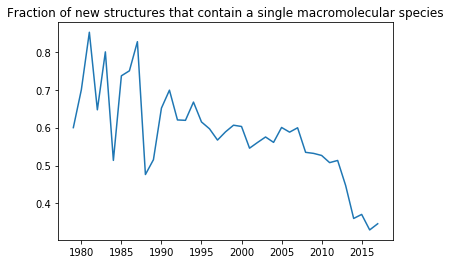

In [71]:
import pandas

rows = []
for bucket in response.raw_content['facets']['deposition_year']['buckets']:
    year = bucket['val']
    total = bucket['count']
    if total > 0:
        for bbucket in bucket['homo_hetero']['buckets']:
            hh = bbucket['val']
            for bbbucket in bbucket['facet']['buckets']:
                rows.append({ 'year': int(year), 'hh':hh, 'mm': bbbucket['val'], 'c':bbbucket['count'] })

df = pandas.DataFrame(rows) 
df = df[df.year>1977]
years = sorted(set(df.year))

homomeric = df[df.hh=='homo'].groupby('year').sum()
heteromeric = df[df.hh=='hetero'].groupby('year').sum()

plt.figure()
plt.plot(years, homomeric/(homomeric+heteromeric) )
plt.title('Fraction of new structures that contain a single macromolecular species')
plt.show()

## Count entries by experiment type

Now let us see a summary of experiment types that have been used to solve carbonic anhydrases.
Since experiment is a property entry, and not molecules within it, we need to group on pdb_id and facet in a group-sensitive way so that the counts we get are for entries.

In [ ]:
response = solr.search(**{
    "rows" : UNLIMITED_ROWS, "fl" : "pdb_id, entity_id",
    "q" : join_with_AND(selectors),
    "facet" : "true", "facet.limit" : UNLIMITED_ROWS, "facet.mincount" : 1,
    "facet.field" : "experimental_method",
    "group" : "true", "group.facet" : "true",
    "group.field" : "pdb_id",
})

expt_counts = response.facets['facet_fields']['experimental_method']
logging.info("There are %d experimental methods with this protein's structure has been studied." % len(expt_counts))
for expt, count in expt_counts.items() :
    logging.info("%s : %d" % (expt,count))

## Count entries by year of deposition

Let us now facet on year of deposition and see the years in which an entry was deposited for carbonic anhydrases.

In [ ]:
response = solr.search(**{
    "rows" : UNLIMITED_ROWS, "fl" : "pdb_id, entity_id",
    "q" : join_with_AND(selectors),
    "facet" : "true", "facet.limit" : UNLIMITED_ROWS, "facet.mincount" : 1,
    "facet.field" : "deposition_year",
    "group" : "true", "group.facet" : "true",
    "group.field" : "pdb_id",
})
year_counts = response.facets['facet_fields']['deposition_year']
logging.info("There are %d years in which this protein's structure has been studied." % len(year_counts))
for year in sorted(year_counts.keys(), key=lambda x : int(x)) :
    logging.info("%s : %d" % (year,year_counts[year]))

Note that we do not have to facet on one field at a time - we could have facetted on multiple fields individually in the same call - just provide comma-separated fields list.

## Range-based facets

Facets can be defined to be range based, e.g. this is useful for fields like resolution, year, length of crystallographic cell, etc.

In [ ]:
response = solr.search(**{
    "rows" : UNLIMITED_ROWS, "fl" : "pdb_id, entity_id",
    "q" : join_with_AND(selectors),
    "facet" : "true", "facet.limit" : UNLIMITED_ROWS, "facet.mincount" : 1,
    "facet.field" : "resolution",
    "facet.range" : "resolution",
    "f.resolution.facet.range.start" : "0.0",
    "f.resolution.facet.range.end" : "100",
    "f.resolution.facet.range.gap" : "0.5",
    "f.resolution.facet.range.other" : "between",
    "f.resolution.facet.range.include" : "upper",
    "group" : "true", "group.facet" : "true",
    "group.field" : "pdb_id",
})

import string, collections

resol_counts = response.facets['facet_ranges']['resolution']['counts']
resol_counts = collections.OrderedDict([(resol_counts[rci], resol_counts[rci+1]) for rci in range(0, len(resol_counts), 2)])
logging.info("Resolutions at which this protein has been solved is as follows:")
for resol in sorted(resol_counts.keys(), key=lambda x : string.atof(x)) :
    logging.info("%3d entries in resolution bin starting %s" % (resol_counts[resol], resol))

## Hierarchical facetting

Factes can be used hierarchically too, e.g. facet first on resolution, then on year, etc.
Unfortunately mysolr does not support this feature, but the good news is that you can write simple python on documents returned and achieve the same effect.
e.g. let us see how to find distribution of resolution vs deposition year in this set of entries.

In [ ]:
response = solr.search(**{
    "rows" : UNLIMITED_ROWS,
    "fl" : "pdb_id, entity_id, deposition_year, resolution",
    "q" : join_with_AND(selectors),
})

resbin_width = 0.5
def resol_bin(resol) :
    import decimal
    return decimal.Decimal(int(resol/resbin_width) * resbin_width)

yearbin_width = 5
def depyear_bin(year) :
    return (year / yearbin_width) * yearbin_width

entry_counted = set()
counts = collections.defaultdict( lambda : collections.defaultdict( lambda: 0 ) )
for adoc in response.documents :
    if adoc['pdb_id'] not in entry_counted :
        res_bin = resol_bin(adoc['resolution'])
        year_bin = depyear_bin(adoc['deposition_year'])
        counts[year_bin][res_bin] += 1

import itertools
year_bins = sorted(counts.keys())
resol_bins = sorted(set( itertools.chain(*[v.keys() for v in counts.values()]) ))

logging.info("          " + "  ".join("%.1f-%.1f" % (rb,float(rb)+resbin_width) for rb in resol_bins))
for year in year_bins :
    to_print = ["%d-%d" % (year,year+yearbin_width)]
    total = 0
    for resol in resol_bins :
        total += counts.get(year, {}).get(resol, 0)
    for resol in resol_bins :
        count = counts.get(year, {}).get(resol, 0)
        to_print.append(count) #, #int(count*100./total),
    logging.info(to_print[0] + "    ".join(["%5d" % tp for tp in to_print[1:]]))

Note how higher resolution structures have increased over the years.

## Your turn!

Find entries with protein of your interest, and facet by organism, genus, etc.